In [8]:
%matplotlib inline
import re
import sys
import math
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict

from evalutils import IntervalForest, populate_index_from_bed, compact
from evalutils import subset_variants_bed, load_kevlar_vcf, load_scalpel_vcf, load_gatk_mvf, load_triodenovo_vcf
import kevlar

seaborn.set_context({'figure.figsize': (24, 12)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [3]:
def roc(calls, index, delta=10, fmt='vcf'):
    ncorrect = 0
    num_true_calls_per_false_call = list()
    for varcall in calls:
        if fmt == 'vcf':
            valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        elif fmt == 'mvf':
            callindex, call = varcall
            valid = index.query(call['CHROM'], call['POS'], delta=delta) != set()
        else:
            raise ValueError('unknown format "'+ fmt +'"')
        if valid:
            ncorrect += 1
            continue
        num_true_calls_per_false_call.append(ncorrect)
    if len(num_true_calls_per_false_call) == 0 or ncorrect > num_true_calls_per_false_call[-1]:
        num_true_calls_per_false_call.append(ncorrect)
    return num_true_calls_per_false_call

In [34]:
def doplot(axis, data, color, label, linestyle, symbol):
    if len(data) == 1:
        alpha = 0.25 if linestyle == ':' else 1.0
        axis.plot([0, 0], data * 2, color=color, linestyle=linestyle, label=label)
        axis.plot([0, 0], data * 2, symbol, alpha=alpha, color=color, markersize=10)
    else:
        axis.plot(range(len(data)), data, color=color, linestyle=linestyle, label=label)
        if linestyle == ':':
            return
        rate = 1
        if len(data) > 10:
            rate = 3
        if len(data) > 50:
            rate = 6
        if len(data) > 200:
            rate = 25
        axis.plot(range(len(data)), data, symbol, color=color, markevery=rate, markersize=6)

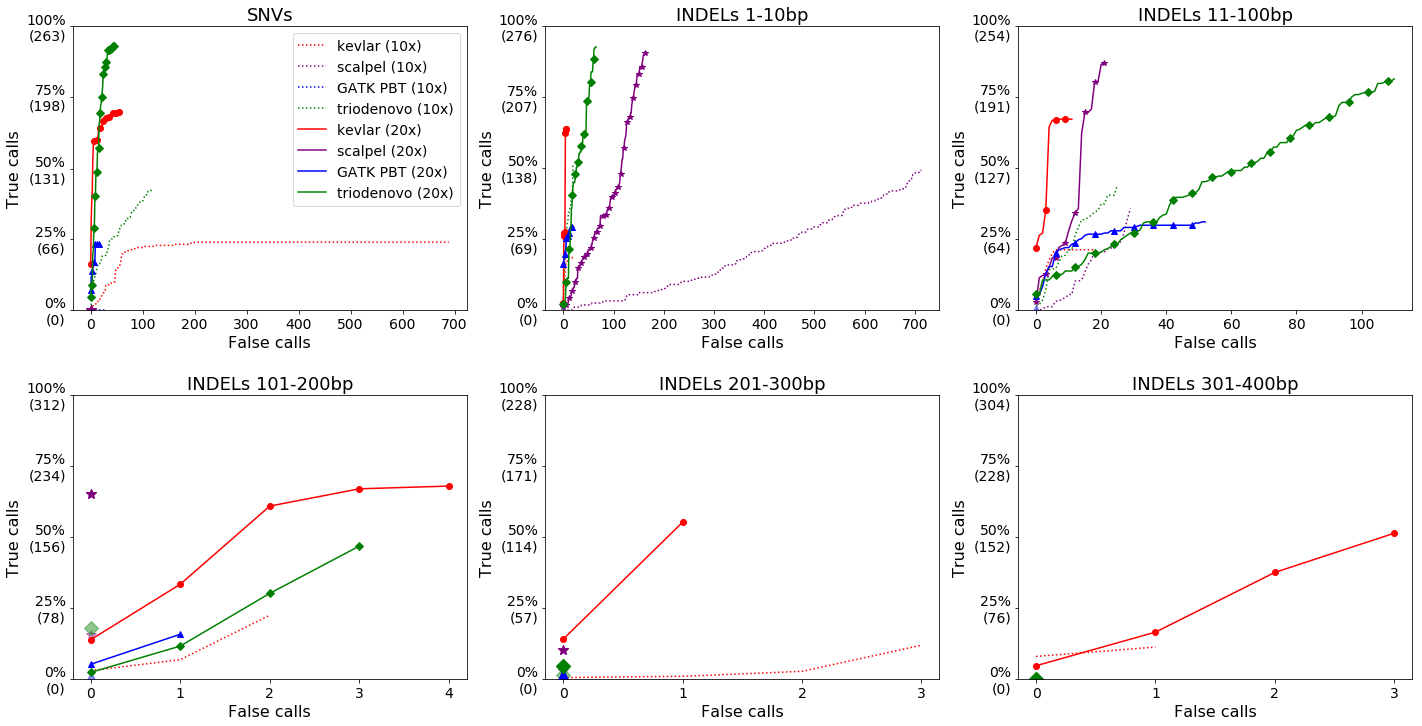

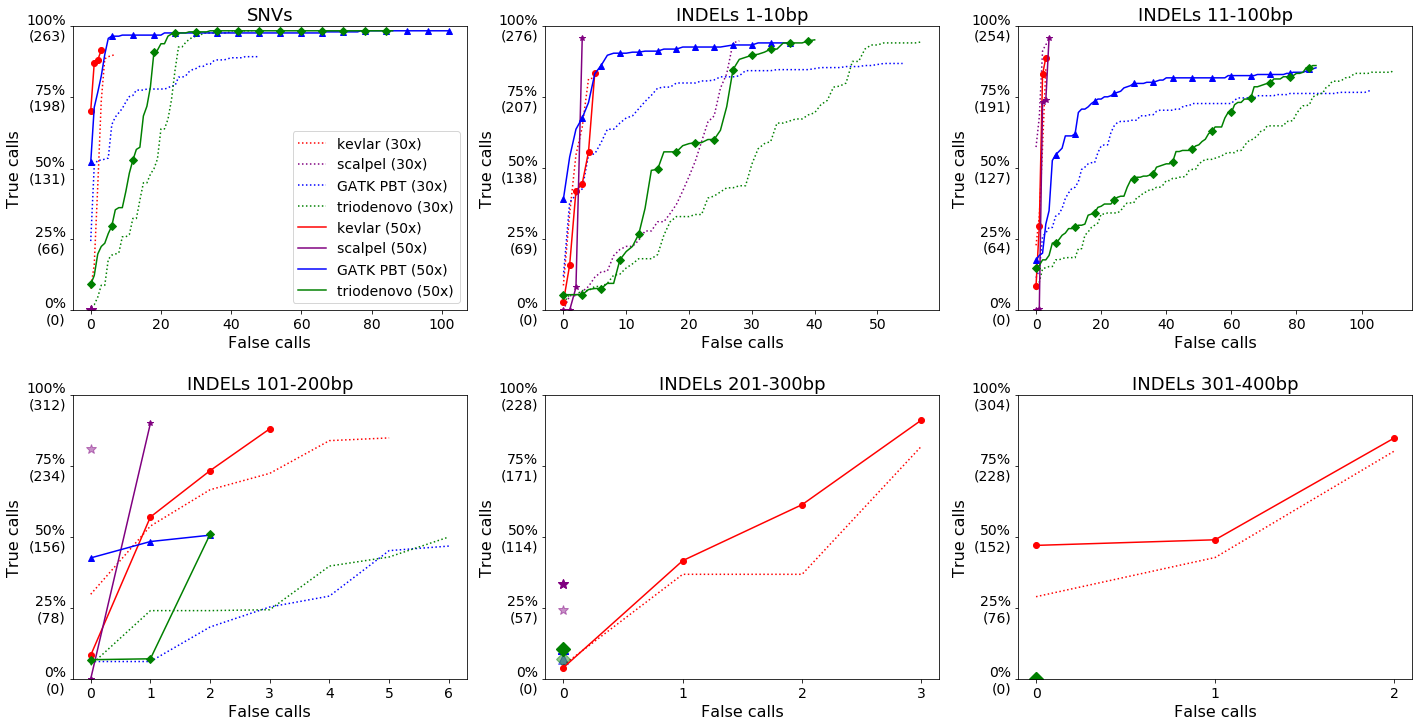

In [39]:
delta = 10
for cov1, cov2, legendloc in (('10', '20', 'upper right'), ('30', '50', 'lower right')):
    categories = [
        ('SNV', None, None, 'SNVs'),
        ('INDEL', 1, 10, 'INDELs 1-10bp'),
        ('INDEL', 11, 100, 'INDELs 11-100bp'),
        ('INDEL', 101, 200, 'INDELs 101-200bp'),
        ('INDEL', 201, 300, 'INDELs 201-300bp'),
        ('INDEL', 301, 400, 'INDELs 301-400bp'),
    ]
    fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3)
    axes = (ax11, ax12, ax13, ax21, ax22, ax23)
    seaborn.set_context({'figure.figsize': (24, 12)})
    
    for i, (category, axis) in enumerate(zip(categories, axes)):
        vartype, minlength, maxlength, label = category
        with kevlar.open('SimulatedVariants_chr17_hg38_markII.bed', 'r') as instream:
            variants = subset_variants_bed(instream, vartype, minlength, maxlength)
            index = populate_index_from_bed(variants)
        
            xaxis_max = -1
            for cov, linestyle in zip((cov1, cov2), (':', '-')):
                kevlar_truecalls = roc(
                    load_kevlar_vcf(
                        'kevlar-newcalls-'+ cov +'x-k31.vcf.gz', index, delta=delta,
                        vartype=vartype, minlength=minlength, maxlength=maxlength
                    ),
                    index, delta=delta, fmt='vcf'
                )
                scalpel_truecalls = roc(
                    load_scalpel_vcf(
                        'scalpel.'+ cov +'x.denovo.indel.vcf', cov=cov,
                        vartype=vartype, minlength=minlength, maxlength=maxlength,
                    ),
                    index, delta=delta, fmt='vcf'
                )
                gatk_truecalls = roc(
                    load_gatk_mvf(
                        'JointCall-'+ cov +'x-PBT.mvf',
                        vartype=vartype, minlength=minlength, maxlength=maxlength
                    ).iterrows(),
                    index, delta=delta, fmt='mvf'
                )
                triodenovo_truecalls = roc(
                    load_triodenovo_vcf(
                        'JointCall-'+ cov +'x-TDN.vcf', cov=cov,
                        vartype=vartype, minlength=minlength, maxlength=maxlength,
                    ),
                    index, delta=delta, fmt='vcf'
                )
                doplot(axis, kevlar_truecalls, 'red', 'kevlar ({}x)'.format(cov), linestyle, 'o')
                doplot(axis, scalpel_truecalls, 'purple', 'scalpel ({}x)'.format(cov), linestyle, '*')
                doplot(axis, gatk_truecalls, 'blue', 'GATK PBT ({}x)'.format(cov), linestyle, '^')
                doplot(axis, triodenovo_truecalls, 'green', 'triodenovo ({}x)'.format(cov), linestyle, 'D')
                xaxis_max = max([xaxis_max, len(kevlar_truecalls), len(gatk_truecalls), len(triodenovo_truecalls)])
            
            nvariants = len(index.trees['chr17'])
            ticknums = [0, math.ceil(nvariants * 0.25), int(nvariants * 0.5), math.ceil(nvariants * 0.75), nvariants]
            ticklabels = ['{:d}%\n({:d})'.format(round(tn / nvariants * 100), tn) for tn in ticknums]
            
            _ = axis.set_xlabel('False calls', fontsize=16)
            if xaxis_max < 6:
                xticknums = list(range(xaxis_max))
                _ = axis.set_xticks(xticknums)
            _ = axis.set_yticks(ticknums)
            _ = axis.set_yticklabels(ticklabels)
            _ = axis.set_ylabel('True calls', fontsize=16)
            _ = axis.set_ylim((0, nvariants))
            _ = axis.set_title(label, fontsize=18)
            if i == 0:
                _ = axis.legend(fontsize=14, loc=legendloc)
    
    _ = plt.subplots_adjust(hspace=0.3)
    _ = plt.savefig('four-callers-'+ cov +'x-combined-new.pdf', dpi=300)
    _ = plt.show()

In [6]:
with kevlar.open('SimulatedVariants_chr17_hg38_markII.bed', 'r') as instream:
    variants = subset_variants_bed(instream, 'SNV')
    index = populate_index_from_bed(variants)

triodenovo_truecalls = roc(
    load_triodenovo_vcf('JointCall-20x-TDN.vcf', cov='20', vartype='SNV'),
    index, delta=delta, fmt='vcf'
)
print(triodenovo_truecalls)
print(len(triodenovo_truecalls))
print(triodenovo_truecalls[-1])
print(len(index.trees['chr17']))
print(triodenovo_truecalls[-1] / len(index.trees['chr17']))

[12, 23, 23, 23, 53, 54, 76, 78, 103, 106, 127, 127, 128, 146, 150, 150, 172, 175, 183, 190, 191, 198, 201, 208, 219, 221, 221, 225, 228, 229, 230, 232, 237, 241, 241, 241, 241, 241, 241, 242, 245, 245, 245, 245, 245, 245, 245, 247]
48
247
263
0.9391634980988594


In [36]:
help(axis.legend)

Help on method legend in module matplotlib.axes._axes:

legend(*args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line.set_label('Label via method')
        line, = ax.plot([1, 2, 3])
        ax.legend()
    
    Specific lines can be excluded from the au